In [3]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2,
                        strongGravityMode=False,
                        gravity=1.5,

                        # Log
                        verbose=True)

# **Reading in the data**

In [2]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import community
import itertools
import networkx.algorithms.community as nx_comm
from networkx.algorithms import bipartite
import re
import csv
from fa2 import ForceAtlas2
import community


folder = "../Movie Dataframe with Ratings/"
df1 = pd.read_pickle(folder+"networkData1.pkl")
df2 = pd.read_pickle(folder+"networkData2.pkl")
df3 = pd.read_pickle(folder+"networkData3.pkl")

frames = [df1, df2, df3]
moviesDf = pd.concat(frames, axis=0, ignore_index=True)


In [4]:
actor_column = list(moviesDf["Actors"].to_numpy())
actors = [actor for cast in actor_column for actor in cast]
duplicates = set(actors) & set(moviesDf["MovieTitle"].to_numpy())
duplicates

# Removing movies where an Actor is called the same
moviesDf.drop(moviesDf[moviesDf['MovieTitle'].isin(duplicates)].index, inplace = True)

**Extracting relevant columns**

In [5]:
genres = (moviesDf['Genres'].to_numpy())
rating_column = moviesDf['Rating'].to_numpy()
genre_column = [re.findall(r"'name': '(.*?)'}", s) for s in genres]
title_column = moviesDf["MovieTitle"].to_numpy()
actor_column = list(moviesDf["Actors"].to_numpy())


#Only using 5 actors
#actor_column5 = []
#for actors in (actor_column):
#    actor_column5.append(actors[:5])
#actor_column = actor_column5
    
actorsDistinct = [*set([actor for cast in actor_column for actor in cast])]

# Creating the graph

**Generating the bipartite network of Actors and Movies**

In [6]:
G = nx.Graph()

#G.add_nodes_from(title_column, bipartite=0)
for i, title in enumerate((title_column)):
    G.add_node(title, bipartite=0, Genres = genre_column[i])
    
G.add_nodes_from(actorsDistinct, bipartite=1)


for i, movie in enumerate(title_column):
    # Adding links between each movie and its actors
    G.add_edges_from(list(zip(itertools.repeat(movie), actor_column[i])))

In [7]:
bipartite.is_bipartite(G)

True

**Basic stats**

In [8]:
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}\n')

Nodes: 137704
Edges: 255020



**Extracting the projected Actor Network and the Movie Network from the biparite graph**

In [9]:
actorNodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1}
movieNodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}

actorNetwork = bipartite.weighted_projected_graph(G, actorNodes, ratio = False)
movieNetwork = bipartite.weighted_projected_graph(G, movieNodes, ratio = False)

In [10]:
print(f'Actor network stats')
print(f'Nodes: {actorNetwork.number_of_nodes()}')
print(f'Edges: {actorNetwork.number_of_edges()}\n')

print(f'Movie network stats')
print(f'Nodes: {movieNetwork.number_of_nodes()}')
print(f'Edges: {movieNetwork.number_of_edges()}\n')

Actor network stats
Nodes: 131746
Edges: 8086719

Movie network stats
Nodes: 5958
Edges: 468645



# Testing stuff

In [11]:
movieEdges = sorted(nx.get_edge_attributes(movieNetwork, 'weight').items(), key=lambda x: x[1], reverse = True)
actorEdges = sorted(nx.get_edge_attributes(actorNetwork, 'weight').items(), key=lambda x: x[1], reverse = True)

In [12]:
movieDegrees = sorted(movieNetwork.degree(weight='weight'), key=lambda x: x[1], reverse=True)
actorDegrees = sorted(actorNetwork.degree(weight='weight'), key=lambda x: x[1], reverse=True)

# Extracting backbone of network

In [13]:
from backbone import *

In [14]:
actorAlphaNetwork = disparity_filter(actorNetwork)
movieAlphaNetwork = disparity_filter(movieNetwork)

In [15]:
#alphaActor = 0.1
alphaActor = 0.12
actorNetworkBackbone = nx.Graph([(u, v, d) for u, v, d in actorAlphaNetwork.edges(data=True) if d['alpha'] < alphaActor])
alphaMovie = 0.12
movieNetworkBackbone = nx.Graph([(u, v, d) for u, v, d in movieAlphaNetwork.edges(data=True) if d['alpha'] < alphaMovie])

In [16]:
#sorted(nx.get_edge_attributes(actorNetworkBackbone, 'alpha').items(), key=lambda x: x[1], reverse = False)
#sorted(nx.get_edge_attributes(actorNetworkBackbone, 'weight').items(), key=lambda x: x[1], reverse = False)

In [17]:
print(f'Actor network backbone stats')
print(f'Nodes: {actorNetworkBackbone.number_of_nodes()}')
print(f'Edges: {actorNetworkBackbone.number_of_edges()}\n')

print(f'Movie network backbone stats')
print(f'Nodes: {movieNetworkBackbone.number_of_nodes()}')
print(f'Edges: {movieNetworkBackbone.number_of_edges()}\n')

Actor network backbone stats
Nodes: 5823
Edges: 23583

Movie network backbone stats
Nodes: 3854
Edges: 13125



In [18]:
movieBackboneDegrees = sorted(movieNetworkBackbone.degree(weight='weight'), key=lambda x: x[1], reverse=True)
actorBackboneDegrees = sorted(actorNetworkBackbone.degree(weight='weight'), key=lambda x: x[1], reverse=True)
actorBackboneDegreesValues = [val for name, val in actorBackboneDegrees]
movieBackboneDegreesValues = [val for name, val in movieBackboneDegrees]

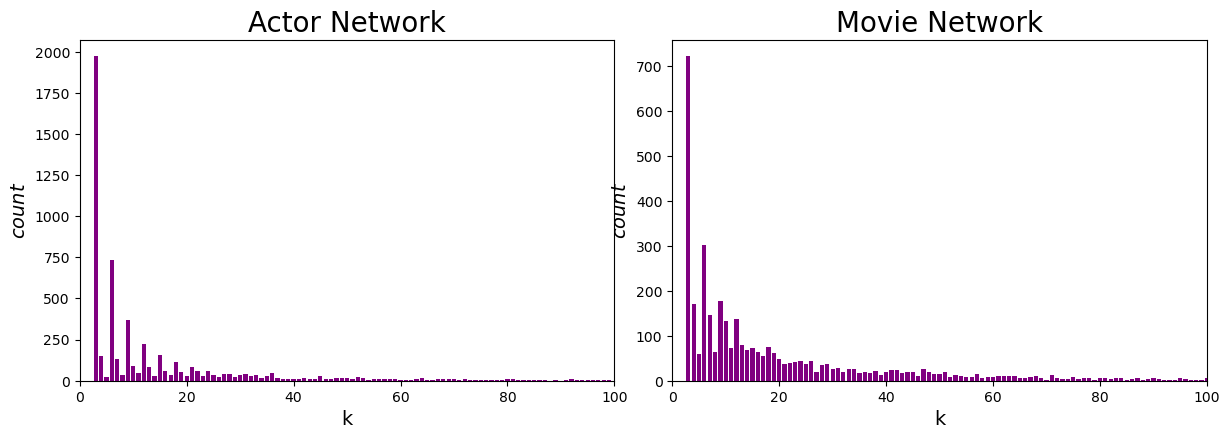

In [19]:
# Binning actors
b = np.arange(np.min(actorBackboneDegreesValues),np.max(actorBackboneDegreesValues),1)
actorFreq, actorBins = np.histogram(actorBackboneDegreesValues, bins = b);
#p_k_sune = [i/np.sum(freq) for i in freq]

# Binning Movies
b = np.arange(np.min(movieBackboneDegreesValues),np.max(movieBackboneDegreesValues),1)
movieFreq, movieBins = np.histogram(movieBackboneDegreesValues, bins = b);
#p_k_sune = [i/np.sum(freq) for i in freq]

# Plotting
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.tight_layout()
ax1.set_title('Actor Network', fontsize = 20)
ax1.set_xlabel('k', fontsize = 14)
ax1.set_ylabel('$count$', fontsize = 14)
ax1.bar(actorBins[:-1], actorFreq, color = 'purple');
ax1.set_xlim(0,100);

ax2.set_title('Movie Network', fontsize = 20)
ax2.set_xlabel('k', fontsize = 14)
ax2.set_ylabel('$count$', fontsize = 14)
ax2.bar(movieBins[:-1], movieFreq, color = 'purple');
ax2.set_xlim(0,100);
plt.show()

# Plotting network Actors

In [20]:
# Removing nodes with very small degree (might be illegal)
remove = [node for node,degree in dict(actorNetworkBackbone.degree()).items() if degree < 4]
actorNetworkBackbone.remove_nodes_from(remove)

In [21]:
# Extracting largest connected component
nodes = max(nx.connected_components(actorNetworkBackbone), key=len)
actorNetworkBackbone = actorNetworkBackbone.subgraph(nodes).copy()

In [22]:
positions = forceatlas2.forceatlas2_networkx_layout(actorNetworkBackbone, pos=None, iterations=100);

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.25it/s]

BarnesHut Approximation  took  2.46  seconds
Repulsion forces  took  3.52  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


In [23]:
d = dict(actorNetworkBackbone.degree).values()
scale = 1
node_size = [degree*scale for degree in d]

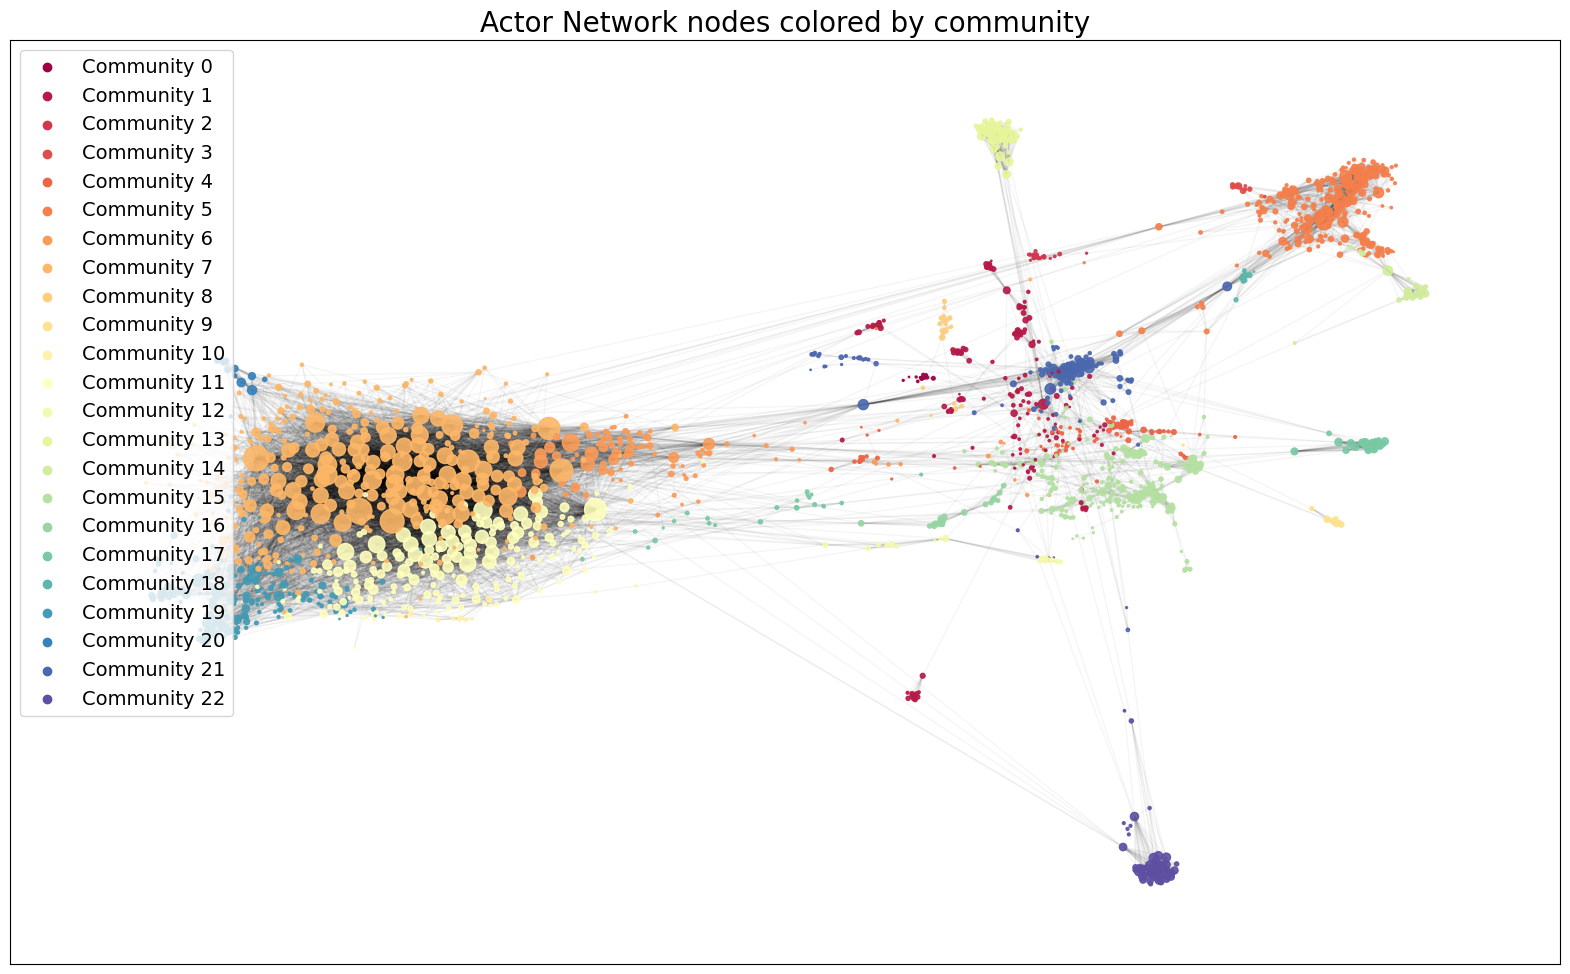

In [24]:
# Best partition found with louvain algorithm
partition = community.best_partition(actorNetworkBackbone, random_state = 1, randomize = False)

# Defining values for the color spectrum
maxval = np.max(list(partition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxval) for v in partition.values()]

# Plotting
fig = plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(actorNetworkBackbone, pos = positions, node_color=node_color, alpha=0.9, node_size = node_size);
nx.draw_networkx_edges(actorNetworkBackbone, pos = positions, alpha=0.04);

# For legend creation only
for v in set(partition.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label='Community {}'.format(v))

plt.title('Actor Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})
plt.savefig('actorNetwork.png')
plt.show()



In [25]:
# rearanging found partition
partsActor = []
for i in range(0, len(set(partition.values()))):
    partsActor.append([])
    
for actor, com in partition.items():
    partsActor[com].append(actor)

#sorting based on biggest communities
partsActorSorted = partsActor
partsActorSorted.sort(key=len, reverse = True)

# Plotting network Movies


In [26]:
# Removing nodes with very small degree (might be illegal)
remove = [node for node,degree in dict(movieNetworkBackbone.degree()).items() if degree < 6]
movieNetworkBackbone.remove_nodes_from(remove)

In [27]:
# Extracting largest connected component
nodes = max(nx.connected_components(movieNetworkBackbone), key=len)
movieNetworkBackbone = movieNetworkBackbone.subgraph(nodes).copy()

In [28]:
positions = forceatlas2.forceatlas2_networkx_layout(movieNetworkBackbone, pos=None, iterations=100);

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.54it/s]

BarnesHut Approximation  took  1.26  seconds
Repulsion forces  took  1.81  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


In [29]:
d = dict(movieNetworkBackbone.degree).values()
scale = 4
node_size = [degree*scale for degree in d]

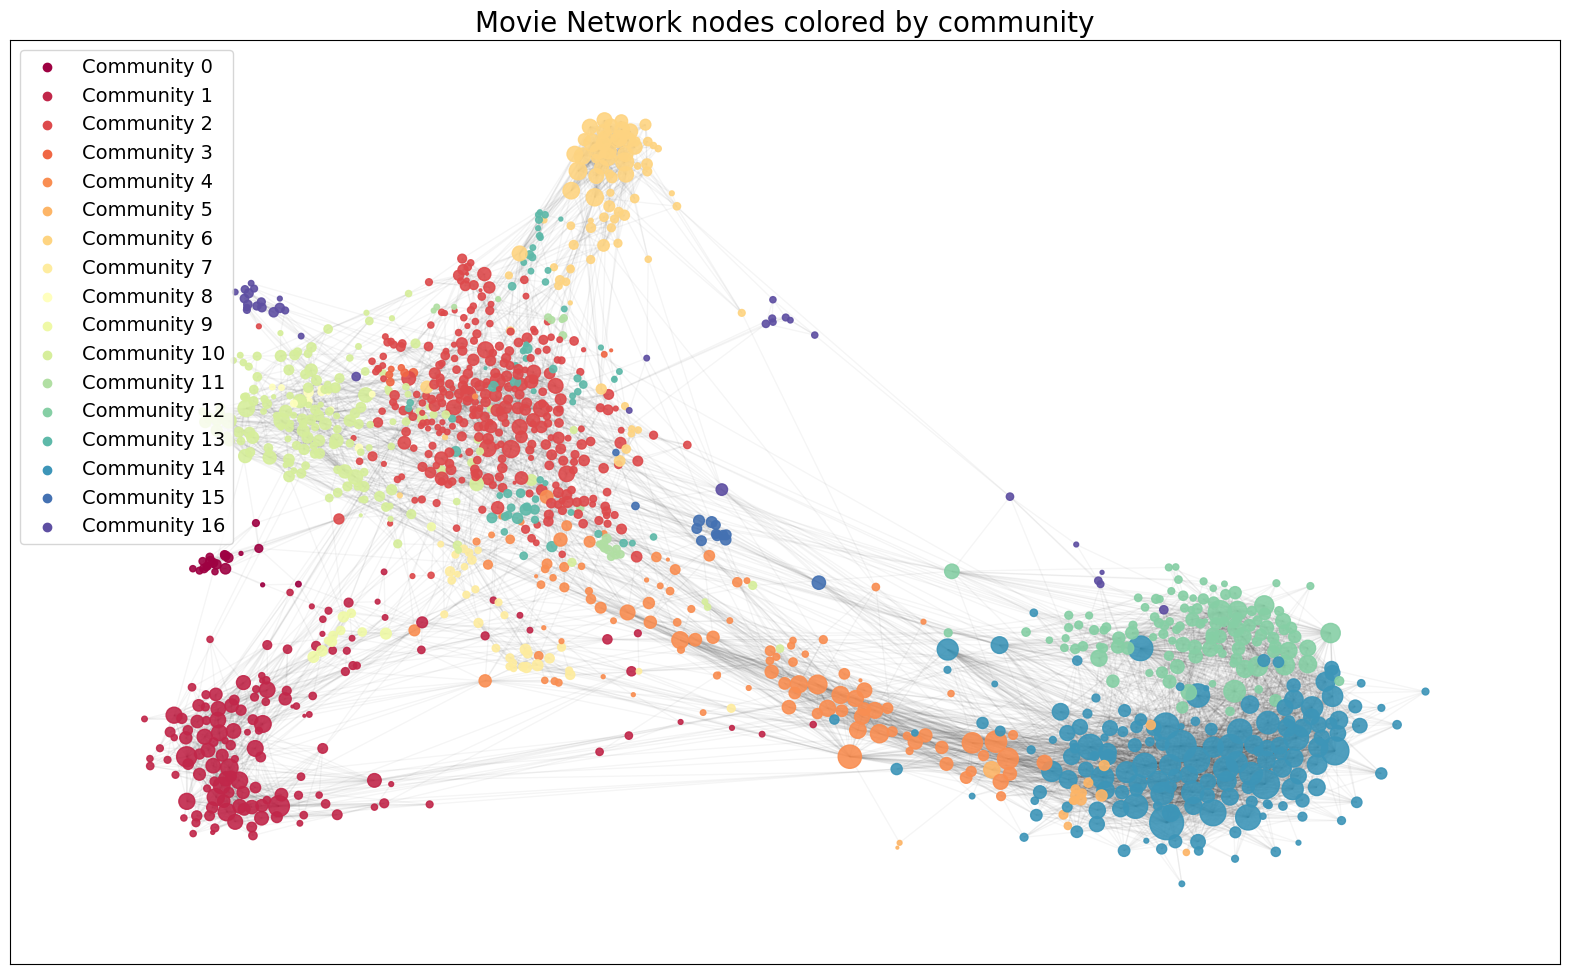

In [30]:
# Best partition found with louvain algorithm
partition = community.best_partition(movieNetworkBackbone, random_state = 1, randomize = False)

# Defining values for the color spectrum
maxval = np.max(list(partition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxval) for v in partition.values()]

# Plotting
plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(movieNetworkBackbone, pos = positions, node_color=node_color, alpha=0.9, node_size = node_size);
nx.draw_networkx_edges(movieNetworkBackbone, pos = positions, alpha=0.04);

# For legend creation only
for v in set(partition.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label='Community {}'.format(v))

plt.title('Movie Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})
plt.savefig('movieNetwork.png')
plt.show()

In [31]:
# rearanging found partition
partsMovie = []
for i in range(0, len(set(partition.values()))):
    partsMovie.append([])
    
for actor, com in partition.items():
    partsMovie[com].append(actor)
    
#sorting based on biggest communities
partsMovieSorted = partsMovie
partsMovieSorted.sort(key=len, reverse = True)

# Analysing found communities

In [32]:
communitySizeActor = [len(com) for com in partsActor]
communitySizeMovie = [len(com) for com in partsMovie]
print(communitySizeActor)
print(communitySizeMovie)

[354, 269, 238, 189, 173, 167, 109, 103, 90, 52, 52, 47, 31, 28, 23, 22, 19, 16, 15, 14, 12, 12, 9]
[311, 156, 155, 140, 115, 107, 80, 63, 34, 32, 21, 20, 16, 15, 13, 11, 8]


In [33]:
for i in partsActor:
    print(i[:5])


['Joe Brooks', 'John Marlin', 'Benjie Bancroft', 'Cosmo Sardo', 'Murray Pollack']
['Steve Buscemi', 'James Lew', 'Al Leong', 'James Caan', 'Mary Ellen Trainor']
['Gene Hackman', 'Don Henderson', 'Ina Clare', 'Derek Lyons', 'Harry Fielder']
['Lars Hensen', 'Michael Jeffers', 'Walter Bacon', 'Charles Sullivan', 'Sam Bagley']
['Paul McMichael', 'Greg Bronson', 'Nicolas Cage', 'Joseph Patrick Kelly', 'Billy Devlin']
['Byron Foulger', 'Ian Wolfe', 'Lester Dorr', 'Eddy Chandler', 'Georges Renavent']
['Kenneth Tobey', 'Peter Renaday', 'John Ratzenberger', 'Tress MacNeille', 'Michael Bell']
['Clark Ross', 'Bob Harks', 'Harry Holcombe', 'Roddy McDowall', 'Eddie Smith']
['Jack Betts', 'Deron McBee', 'Michael Paul Chan', 'Kimberly Scott', 'John Fink']
['Fred MacMurray', 'Keenan Wynn', 'Ben Wright', 'James MacDonald', 'Don Rickles']
['John Dennis', 'Dennis Quaid', 'Allan Graf', 'Lin Shaye', 'Peter Jason']
['Larry Miller', 'Shannon Wilcox', 'Marvin Braverman', 'Hector Elizondo', 'Patrick Richwood']

In [34]:
print(f'Actor network backbone stats')
print(f'Nodes: {actorNetworkBackbone.number_of_nodes()}')
print(f'Edges: {actorNetworkBackbone.number_of_edges()}\n')

print(f'Movie network backbone stats')
print(f'Nodes: {movieNetworkBackbone.number_of_nodes()}')
print(f'Edges: {movieNetworkBackbone.number_of_edges()}\n')

Actor network backbone stats
Nodes: 2044
Edges: 18478

Movie network backbone stats
Nodes: 1297
Edges: 8709



In [35]:
movieBackboneDegrees = sorted(movieNetworkBackbone.degree(), key=lambda x: x[1], reverse=True)
actorBackboneDegrees = sorted(actorNetworkBackbone.degree(), key=lambda x: x[1], reverse=True)

In [41]:
movieBackboneDegrees

[('Calamity Jane', 148),
 ('Around the World in Eighty Days', 123),
 ('Giant', 110),
 ('The Band Wagon', 100),
 ('White Christmas', 89),
 ('Pocketful of Miracles', 87),
 ('Witness for the Prosecution', 86),
 ('4 for Texas', 82),
 ('Inherit the Wind', 82),
 ('An Affair to Remember', 80),
 ('Mighty Joe Young', 79),
 ('The Bad and the Beautiful', 79),
 ('How to Murder Your Wife', 76),
 ('Designing Woman', 76),
 ('Gentlemen Prefer Blondes', 76),
 ('The Manchurian Candidate', 75),
 ('Mr. Smith Goes to Washington', 71),
 ('Blazing Saddles', 70),
 ('Titanic', 70),
 ('North by Northwest', 66),
 ('Gypsy', 65),
 ('My Man Godfrey', 65),
 ('The Great Race', 64),
 ('The War of the Worlds', 63),
 ('The Greatest Show on Earth', 60),
 ('Torn Curtain', 59),
 ('Pal Joey', 58),
 ('Monsieur Verdoux', 58),
 ("Ocean's Eleven", 57),
 ('The Computer Wore Tennis Shoes', 57),
 ('Our Man Flint', 57),
 ('A Night to Remember', 56),
 ('The Man Who Shot Liberty Valance', 56),
 ('When Worlds Collide', 56),
 ('Friendl

In [37]:
list(bipartite.maximum_matching(G, partsActor[-2]))

['Kenneth W Caravan',
 'Jimmy Yuill',
 'Emma Thompson',
 'Richard Clifford',
 'Brian Blessed',
 'Michael Maloney',
 'Helena Bonham Carter',
 'Patrick Doyle',
 'Edward Jewesbury',
 'Ian Holm',
 'Kenneth Branagh',
 'Richard Briers',
 'Sense and Sensibility',
 'Richard III',
 'Robin Hood: Prince of Thieves',
 'Mighty Aphrodite',
 'Frankenstein',
 'Much Ado About Nothing',
 "A Midwinter's Tale",
 'Carrington',
 'Othello',
 'Henry V',
 'Anne Frank Remembered',
 'The Madness of King George']

In [43]:
partsActor[1]

['Steve Buscemi',
 'James Lew',
 'Al Leong',
 'James Caan',
 'Mary Ellen Trainor',
 'Selma Archerd',
 'Larry Clardy',
 'Tony Burton',
 'Woody Allen',
 'Steve Kahan',
 'Traci Wolfe',
 'Bill Henderson',
 'Kenneth Tigar',
 'Henry Brown',
 'Marian Collier',
 'John Harms',
 'Stephen Liska',
 'Jack McGee',
 'Mel Gibson',
 'Danny Glover',
 'James Oliver',
 'Paul Tuerpe',
 'Jay Della',
 'Danny Wynands',
 'Joe Pesci',
 'Bert Remsen',
 'Damon Hines',
 'Darlene Love',
 'Ebonie Smith',
 'Richard Donner',
 'Michael McKean',
 'Marshall Dancing Elk Lucas',
 'Bill Nunn',
 'Giancarlo Esposito',
 'Joie Lee',
 'John Turturro',
 'Spike Lee',
 'Nelson Vasquez',
 'Peter Appel',
 'Steve White',
 'Roger Guenveur Smith',
 'John Cazale',
 'Tere Livrano',
 'Robert Duvall',
 'Richard Bright',
 'Al Pacino',
 'Sofia Coppola',
 'Talia Shire',
 'Diane Keaton',
 'Robert De Niro',
 'Meryl Streep',
 'Billy Crystal',
 'Paul Herman',
 'Garry Pastore',
 'Vinny Vella',
 'Joseph Bono',
 'Martin Scorsese',
 'Catherine Scorses

In [39]:
genrelist = nx.get_node_attributes(G, 'Genres')

In [40]:
com = partsMovie[6]
genreAtt = G.nodes(data='Genres')
for movie in com:
    print(f'{movie:<40}{genreAtt[movie][0]}')

Look Who's Talking Now!                 Romance
Who Framed Roger Rabbit                 Fantasy
Oscar and Lucinda                       Drama
Muriel's Wedding                        Drama
Babe: Pig in the City                   Adventure
Anastasia                               Animation
Mulan                                   Animation
Me, Myself & Irene                      Comedy
The Fabulous Baker Boys                 Music
Oliver & Company                        Animation
Jaws: The Revenge                       Adventure
Final Fantasy: The Spirits Within       Adventure
Lilo & Stitch                           Animation
Babe                                    Fantasy
Gross Anatomy                           Comedy
What's the Worst That Could Happen?     Action
There's Something About Mary            Romance
Dumb and Dumber                         Comedy
Osmosis Jones                           Adventure
Kingpin                                 Comedy
Shallow Hal                        

In [45]:
pd.to_pickle(partsActor, 'ActorCommunities.pkl')